# Kaggle Playground 

### Problem Statement / Real World Implementations

### 1. Importing Libraries

In [15]:
# Core Data Science Libraries
import numpy as np
import pandas as pd
import warnings

# Visualization Libraries
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Scikit-learn for Preprocessing and Modeling
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Machine Learning Models
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor,
    BaggingRegressor
)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Hyperparameter Tuning
import optuna

# Notebook settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### 2. Loading Dataset

In [2]:
# Define file paths
TRAIN_PATH = "/kaggle/input/playground-series-s5e11/train.csv"
TEST_PATH = "/kaggle/input/playground-series-s5e11/test.csv"
SUBMISSION_PATH = "/kaggle/input/playground-series-s5e11/sample_submission.csv"

# Load the datasets into pandas DataFrames
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
submission_df = pd.read_csv(SUBMISSION_PATH)

In [3]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (593994, 13)
Test shape: (254569, 12)


In [4]:
df=train_df
df.head(5)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [5]:
print(df["gender"].unique())
print(df["marital_status"].unique())
print(df["education_level"].unique())
print(df["employment_status"].unique())
print(df["loan_purpose"].unique())
print(df["grade_subgrade"].unique())

['Female' 'Male' 'Other']
['Single' 'Married' 'Divorced' 'Widowed']
['High School' "Master's" "Bachelor's" 'PhD' 'Other']
['Self-employed' 'Employed' 'Unemployed' 'Retired' 'Student']
['Other' 'Debt consolidation' 'Home' 'Education' 'Vacation' 'Car'
 'Medical' 'Business']
['C3' 'D3' 'C5' 'F1' 'D1' 'D5' 'C2' 'C1' 'F5' 'D4' 'C4' 'D2' 'E5' 'B1'
 'B2' 'F4' 'A4' 'E1' 'F2' 'B4' 'E4' 'B3' 'E3' 'B5' 'E2' 'F3' 'A5' 'A3'
 'A1' 'A2']


In [6]:
df.isna().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [7]:
df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


### 4. EDA

In [ ]:
# Select only numeric columns for correlation matrix
numerical_cols = train_df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('id')
numerical_cols.remove('loan_paid_back')

numeric_df = train_df[numerical_cols + ['loan_paid_back']]
corr_matrix = numeric_df.corr()

# Create the interactive heatmap
fig = go.Figure(data=go.Heatmap(
                   z=corr_matrix.values,
                   x=corr_matrix.columns,
                   y=corr_matrix.columns,
                   colorscale='RdBu_r',
                   zmin=-1, zmax=1,
                   text=corr_matrix.round(2).values,
                   texttemplate="%{text}",
                   hoverongaps=False))

fig.update_layout(
    title='Correlation Heatmap of Numerical Features',
    width=800, height=800
)
fig.show()

### 3. Normalization of data

In [12]:
def encode_features(df):
    df_encoded = df.copy()
    
    # Boolean to integer
    for col in df_encoded.select_dtypes(include='bool').columns:
        df_encoded[col] = df_encoded[col].astype(int)
        
    # Categorical to integer
    categorical_cols = df_encoded.select_dtypes(include='object').columns
    if len(categorical_cols) > 0:
        encoder = OrdinalEncoder()
        df_encoded[categorical_cols] = encoder.fit_transform(df_encoded[categorical_cols])
    
    return df_encoded

train_ids = train_df['id']
test_ids = test_df['id']

train_processed = encode_features(train_df.drop('id', axis=1))
test_processed = encode_features(test_df.drop('id', axis=1))

In [13]:
df.head(5)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


Summary Statistics:



,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,48212.202976,0.120696,680.916009,15020.297629,12.356345,0.490825,1.472616,0.831498,0.685438,2.609976,13.967705,0.798820
std,26711.942078,0.068573,55.424956,6926.530568,2.008959,0.512317,0.585860,0.972475,1.332355,1.656488,5.115538,0.400883
min,6002.430000,0.011000,395.000000,500.090000,3.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27934.400000,0.072000,646.000000,10279.620000,10.990000,0.000000,1.000000,0.000000,0.000000,2.000000,11.000000,1.000000
50%,46557.680000,0.096000,682.000000,15000.220000,12.370000,0.000000,1.000000,1.000000,0.000000,2.000000,13.000000,1.000000
75%,60981.320000,0.156000,719.000000,18858.580000,13.680000,1.000000,2.000000,1.000000,0.000000,3.000000,17.000000,1.000000
max,393381.740000,0.627000,849.000000,48959.950000,20.990000,2.000000,3.000000,4.000000,4.000000,7.000000,29.000000,1.000000



Feature Ranges:

annual_income           387379.310
loan_amount              48459.860
credit_score               454.000
grade_subgrade              29.000
interest_rate               17.790
loan_purpose                 7.000
employment_status            4.000
education_level              4.000
marital_status               3.000
gender                       2.000
loan_paid_back               1.000
debt_to_income_ratio         0.616
dtype: float64


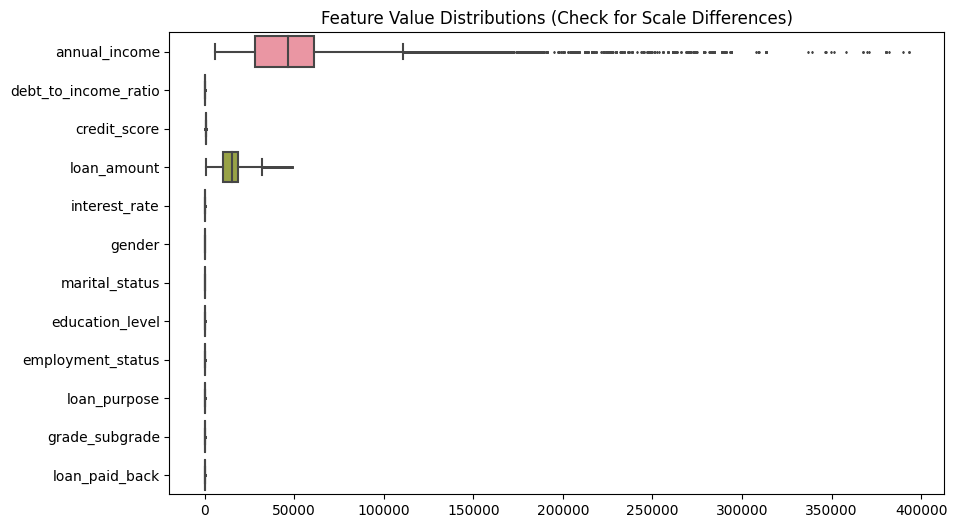


Features with significantly higher ranges: ['annual_income', 'loan_amount']

✅ Feature scaling is likely necessary (large scale differences detected).


In [16]:
# Exclude target column if present
features = train_processed.drop(columns=['accident_risk'], errors='ignore')

# 1. Check summary statistics
print("Summary Statistics:\n")
display(features.describe())

# 2. Check for large differences in scale
range_df = features.max() - features.min()
print("\nFeature Ranges:\n")
print(range_df.sort_values(ascending=False))

# 3. Visualize distribution of feature scales
plt.figure(figsize=(10, 6))
sns.boxplot(data=features, orient='h', fliersize=1)
plt.title("Feature Value Distributions (Check for Scale Differences)")
plt.show()

# 4. Correlation check
corr_matrix = features.corr()
high_range_features = range_df[range_df > range_df.mean()].index.tolist()
print(f"\nFeatures with significantly higher ranges: {high_range_features}")

# 5. Quick rule-based decision
if range_df.max() / range_df.min() > 10:
    print("\n✅ Feature scaling is likely necessary (large scale differences detected).")
else:
    print("\n❌ Feature scaling might not be strictly necessary (features on similar scales).")

### Train test split

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
import numpy as np

# Use encoded data for model training
X = train_processed.drop("loan_paid_back", axis=1)
y = train_processed["loan_paid_back"]

# Ensure all columns are numeric
X = X.select_dtypes(include=[np.number])

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Choose scaling method
selected_method = 'Standard Scaling'

# Apply the best scaling method
if selected_method == 'Min-Max Scaling':
    scaler = MinMaxScaler()
elif selected_method == 'Standard Scaling':
    scaler = StandardScaler()
elif selected_method == 'Robust Scaling':
    scaler = RobustScaler()
elif selected_method == 'Power Transformation':
    scaler = PowerTransformer(method='yeo-johnson')
else:
    scaler = None  # Log or Decimal handled separately

# Perform scaling
if scaler is not None:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
elif selected_method == 'Log Transformation':
    X_train_scaled = np.log1p(X_train.clip(lower=1e-6))
    X_test_scaled = np.log1p(X_test.clip(lower=1e-6))
elif selected_method == 'Decimal Scaling':
    X_train_scaled = X_train / 100.0
    X_test_scaled = X_test / 100.0
else:
    X_train_scaled = X_train
    X_test_scaled = X_test

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize models
models = [
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    XGBRegressor(),
    AdaBoostRegressor(),
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    LGBMRegressor(),
    BaggingRegressor(),
    ExtraTreesRegressor()
]

print("🔍 Evaluating Models...\n")
mse_scores = []

for model in models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    print(f"{model.__class__.__name__:<30} MSE: {mse:.5f}")

# Select best model
best_model_default = models[np.argmin(mse_scores)]
print("\n✅ Best Model Based on MSE:", best_model_default.__class__.__name__)

🔍 Evaluating Models...

DecisionTreeRegressor          MSE: 0.15190
RandomForestRegressor          MSE: 0.07589
XGBRegressor                   MSE: 0.07267
AdaBoostRegressor              MSE: 0.09167
KNeighborsRegressor            MSE: 0.09169
GradientBoostingRegressor      MSE: 0.07433
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1335
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 11
[LightGBM] [Info] Start training from score 0.799024
LGBMRegressor                  MSE: 0.07270
BaggingRegressor               MSE: 0.08319
ExtraTreesRegressor            MSE: 0.07695

✅ Best Model Based on MSE: XGBRegressor


In [19]:
# Evaluate final model
y_pred = best_model_default.predict(X_test_scaled)

mse_default = mean_squared_error(y_test, y_pred)
mae_default = mean_absolute_error(y_test, y_pred)
r2_default = r2_score(y_test, y_pred)

print("\n📊 Final Model Evaluation:")
print(f"Mean Squared Error : {mse_default:.5f}")
print(f"Mean Absolute Error: {mae_default:.5f}")
print(f"R² Score           : {r2_default:.5f}")


📊 Final Model Evaluation:
Mean Squared Error : 0.07267
Mean Absolute Error: 0.14780
R² Score           : 0.54915


### Selecting best model and Generating Submission

In [20]:
print("\n🚀 Retraining the best model on full training data...")

# Prepare full training features and target
X_full = train_processed.drop(columns=['loan_paid_back'], errors='ignore')
y_full = train_processed['loan_paid_back']

# Ensure all columns are numeric
X_full = X_full.select_dtypes(include=[np.number])

# Scale full data using the same scaler
if scaler is not None:
    X_full_scaled = scaler.fit_transform(X_full)
else:
    X_full_scaled = X_full

# Retrain best model on the full scaled dataset
best_model_default.fit(X_full_scaled, y_full)

print(f"✅ Model retrained successfully: {best_model_default.__class__.__name__}\n")


🚀 Retraining the best model on full training data...
✅ Model retrained successfully: XGBRegressor



In [21]:
# Keep IDs for submission if available
if 'id' in test_df.columns:
    test_ids = test_df['id']
else:
    test_ids = range(len(test_df))  # create sequential IDs if missing

# Encode test data (using your encode_features function)
test_processed = encode_features(test_df.drop('id', axis=1, errors='ignore'))

# Ensure numeric columns only
X_submission = test_processed.select_dtypes(include=[np.number])

# Scale using the same scaler
if scaler is not None:
    X_submission_scaled = scaler.transform(X_submission)
else:
    X_submission_scaled = X_submission

In [22]:
print("🔮 Generating predictions using the best model...")
submission_preds = best_model_default.predict(X_submission_scaled)

# Optional: clip predictions to valid range [0, 1]
submission_preds = np.clip(submission_preds, 0, 1)

🔮 Generating predictions using the best model...


In [23]:
submission = pd.DataFrame({
    'id': test_ids,
    'loan_paid_back': submission_preds
})

submission.to_csv('submission.csv', index=False)

print("\n✅ Submission file 'submission.csv' generated successfully!")
display(submission.head())


✅ Submission file 'submission.csv' generated successfully!


,id,loan_paid_back
0,593994,0.971107
1,593995,0.980793
2,593996,0.371168
3,593997,0.910102
4,593998,0.947453


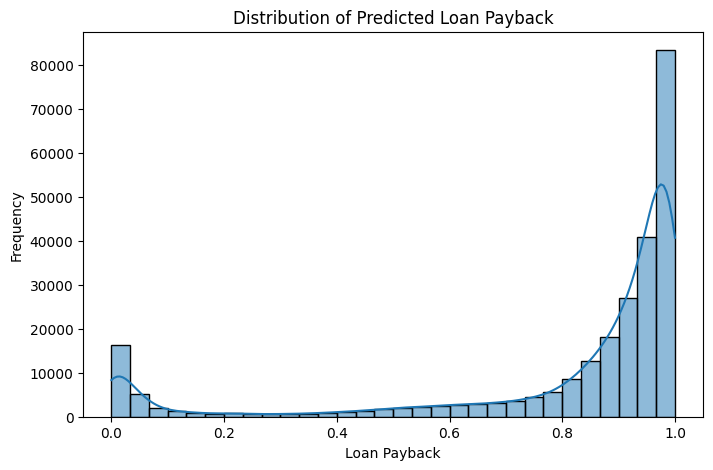

In [24]:
plt.figure(figsize=(8, 5))
sns.histplot(submission['loan_paid_back'], bins=30, kde=True)
plt.title('Distribution of Predicted Loan Payback')
plt.xlabel('Loan Payback')
plt.ylabel('Frequency')
plt.show()